In [8]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv(r'/kaggle/input/house-price/1553768847-housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


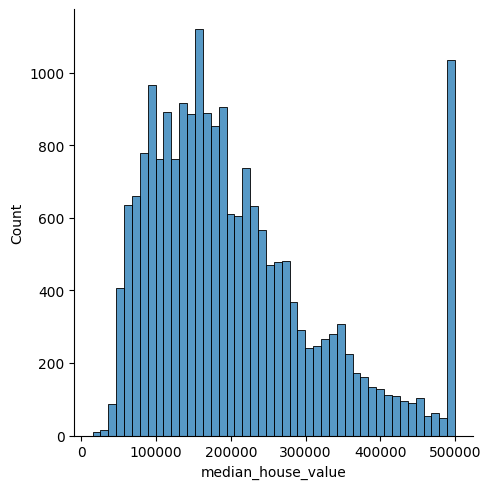

In [10]:
sns.displot(x = df['median_house_value'], data = df)

In [15]:
def summary(df):
    print('California House Price Dataframe Dimensions : ', df.shape)
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary['null'] = df.isnull().sum()
    print('\nSummary Table:')
    return summary

summary(df)

California House Price Dataframe Dimensions :  (20640, 10)

Summary Table:


,dtypes,null
longitude,float64,0
latitude,float64,0
housing_median_age,int64,0
total_rooms,int64,0
total_bedrooms,float64,207
population,int64,0
households,int64,0
median_income,float64,0
ocean_proximity,object,0
median_house_value,int64,0


In [18]:
# Handling missing data
df.fillna(df['total_bedrooms'].mean(),inplace=True)
summary(df)

California House Price Dataframe Dimensions :  (20640, 10)

Summary Table:


,dtypes,null
longitude,float64,0
latitude,float64,0
housing_median_age,int64,0
total_rooms,int64,0
total_bedrooms,float64,0
population,int64,0
households,int64,0
median_income,float64,0
ocean_proximity,object,0
median_house_value,int64,0


In [21]:
# Converting categorical feature "ocean_proximity" to numerical data
updated_df = pd.get_dummies(df, prefix=['To Ocean'])
updated_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,To Ocean_<1H OCEAN,To Ocean_INLAND,To Ocean_ISLAND,To Ocean_NEAR BAY,To Ocean_NEAR OCEAN
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,0,0,0,1,0
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,0,0,0,1,0
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,0,0,0,1,0
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,0,0,0,1,0
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,0,0,0,1,0


In [22]:
# Extracting input (X) and output (y) data from the dataset
X = updated_df.drop('median_house_value', axis=1)
y = updated_df['median_house_value']

In [30]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [32]:
from torch.utils.data import Dataset, DataLoader
class CSVDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [33]:
training_data = CSVDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_data = CSVDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [34]:
epoch = 100
batch_size = 32
learning_rate = 0.001
features = len(X.columns)

In [38]:
training_loader = DataLoader(dataset = training_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = 1)

In [56]:
class MultiFeatureRegression(torch.nn.Module):
    def __init__(self, features):
        super(MultiFeatureRegression, self).__init__()
        self.layer_1 = torch.nn.Linear(features, 64)
        self.layer_2 = torch.nn.Linear(64, 128)
        self.layer_3 = torch.nn.Linear(128, 64)
        self.layer_output = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, inputs):
        output = self.relu(self.layer_1(inputs))
        output = self.relu(self.layer_2(output))
        output = self.relu(self.layer_3(output))
        output = self.layer_output(output)
        return(output)
    
    def predict(self, test_inputs):
        output = self.relu(self.layer_1(test_inputs))
        output = self.relu(self.layer_2(output))
        output = self.relu(self.layer_3(output))
        output = self.layer_output(output)
        return(output)

In [58]:
processor = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Processor is', processor)

Processor is cpu


In [59]:
model = MultiFeatureRegression(features)
model.to(processor)

MultiFeatureRegression(
  (layer_1): Linear(in_features=13, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [60]:
criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [64]:
# Performing training and testing
from tqdm.notebook import tqdm
for e in tqdm(range(1, epoch + 1)):
    training_epoch_loss = 0
    model.train()
    for X_training_set, y_training_set in training_loader:
        X_training_set, y_training_set = X_training_set.to(processor), y_training_set.to(processor)
        optimizer.zero_grad()
        y_training_pred = model(X_training_set)
        training_loss = criterion(y_training_pred, y_training_set.unsqueeze(1))
        training_loss.backward()
        optimizer.step()
        training_epoch_loss += training_loss.item()
               
    with torch.no_grad():
        test_epoch_loss = 0
        model.eval()
        for X_test_set, y_test_set in test_loader:
            X_test_set, y_test_set = X_test_set.to(processor), y_test_set.to(processor)
            y_test_pred = model(X_test_set)
            val_loss = criterion(y_test_pred, y_test_set.unsqueeze(1))
            test_epoch_loss += val_loss.item()
    loss_stats['train'].append(training_epoch_loss / len(training_loader))
    loss_stats['test'].append(test_epoch_loss / len(test_loader))                              
    
    if epoch % 10 == 0:
        print(f'Epoch {e + 0:03}: | Training Loss: {training_epoch_loss / len(training_loader):.2f} | Test Loss: {test_epoch_loss / len(test_loader):.2f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Training Loss: 47290.74 | Test Loss: 47859.37
Epoch 002: | Training Loss: 47177.95 | Test Loss: 47912.73
Epoch 003: | Training Loss: 47090.55 | Test Loss: 47818.23
Epoch 004: | Training Loss: 47007.03 | Test Loss: 47713.27
Epoch 005: | Training Loss: 46916.25 | Test Loss: 47691.42
Epoch 006: | Training Loss: 46812.95 | Test Loss: 47594.33
Epoch 007: | Training Loss: 46729.10 | Test Loss: 47523.88
Epoch 008: | Training Loss: 46648.32 | Test Loss: 47470.54
Epoch 009: | Training Loss: 46565.05 | Test Loss: 47466.28
Epoch 010: | Training Loss: 46505.03 | Test Loss: 47519.29
Epoch 011: | Training Loss: 46416.67 | Test Loss: 47375.59
Epoch 012: | Training Loss: 46315.65 | Test Loss: 47391.99
Epoch 013: | Training Loss: 46274.15 | Test Loss: 47265.79
Epoch 014: | Training Loss: 46206.03 | Test Loss: 47144.53
Epoch 015: | Training Loss: 46116.67 | Test Loss: 47075.27
Epoch 016: | Training Loss: 46064.60 | Test Loss: 47263.65
Epoch 017: | Training Loss: 46025.30 | Test Loss: 47020.

Text(0.5, 1.0, 'Training - Test Loss/Epoch')

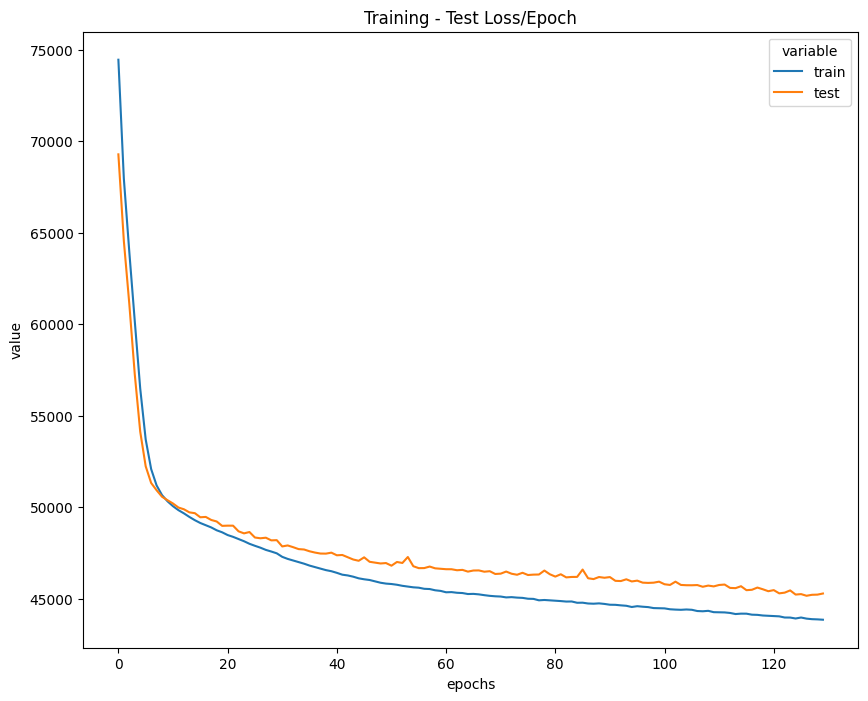

In [74]:
training_test_loss = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={'index' : 'epochs'})
plt.figure(figsize = (10, 8))
sns.lineplot(data = training_test_loss, x = 'epochs', y = 'value', hue = 'variable').set_title('Training - Test Loss/Epoch')

In [75]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_set, _ in test_loader:
        X_set = X_set.to(processor)
        y_test_pred = model(X_set)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [77]:
# Quantifying the quality of predictions
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
mae = mean_absolute_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
msle = mean_squared_log_error(y_test, y_pred_list)
print('Mean Absolute Error :', mae)
print('R Squared :', r_square)
print('MSLE:', msle)

Mean Absolute Error : 45287.95622596445
R Squared : 0.6407876719275931
MSLE: 0.09878025833792954
